In [25]:
from math import sqrt
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from itertools import count
import networkx as nx
import time
from collections.abc import Iterable
from matplotlib import patches
import matplotlib.gridspec as gridspec

In [26]:
with open('./initializer/dataset_3.txt', 'r') as file:
    parameters = [int(x) for x in file.readline().split(' ')[:]]
    rows = [[int(x) for x in line.split(' ')[:]] for line in file]
    cols = [list(col) for col in zip(*rows)]

x_cords = cols[0]
y_cords = cols[1]
m_amount = cols[2]

n_islands, p_cost_factor, k_consicutive_islands, money_limit  = parameters[0], parameters[1], parameters[2], parameters[3]

cords_data = list(zip(x_cords, y_cords))
#list_cords = [list(a) for a in zip(x_cords, y_cords)]
name2point = {i: j for i, j in zip(count(start=0, step=1), cords_data)}
point2name = {y: x for x,y in name2point.items()}

cords2money = {i: j for i, j in zip(cords_data, m_amount)}
island2money = {i: j for i, j in zip(count(start=0, step=1), m_amount)}

In [27]:
def reaching_cost(p1, p2):
    return p_cost_factor * (sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2))

def Indexed_reachingCost(ip1, ip2):
    global cords_data
    p1 = cords_data[ip1]
    p2 = cords_data[ip2]
    return p_cost_factor * (sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2))

def factor_calc(currentIsland, nextIsland):
    pc_factor = island2money[nextIsland] - Indexed_reachingCost(nextIsland, currentIsland)
    return pc_factor

Episode 1 - Smart selection approach

In [28]:
def buildEdges(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return list(zip(a, b))

def tourCost(tour):
    edge_list = buildEdges(tour)
    totalCost = sum(Indexed_reachingCost(*e) for e in edge_list)
    return totalCost
    
def tourProfit(tour):
    CircuitCords = [name2point[a] for a in tour]
    totalProfit = sum(cords2money[i] for i in CircuitCords)
    return totalProfit

def tourFactor(tour):
    factor = tourProfit(tour) - tourCost(tour)
    return factor

In [29]:
def limitExceeded(circuit, current_vertex=0, start_vertex=0):
    if any(isinstance(el, Iterable) for el in circuit):
        circuitCost = sum(Indexed_reachingCost(*e) for e in circuit) + Indexed_reachingCost(current_vertex, start_vertex) 
        OutputCircuit = [a for (a, b) in circuit]
        CircuitCords = [name2point[a] for a in OutputCircuit]
        circuitProfit = sum(cords2money[i] for i in CircuitCords) - island2money[0]
        netProfit = circuitProfit - circuitCost
    else:
        netProfit = tourFactor(circuit)
        
    return netProfit > money_limit
    

In [30]:
# instead of choosing the nearest island we are choosing the island with the best netProfit = profit-cost factor        
def BestFactor_circuit(cord):
    cord = cords_data
    circuit = list()
    start_vertex = 0
    dark_side = set(range(n_islands)) - {start_vertex}

    current_vertex = start_vertex
    while len(dark_side) > 0:
        if limitExceeded(circuit, current_vertex, start_vertex):
            break
        max_factor = None
        best_v = None
        for v in dark_side:
            if ((max_factor is None) or (max_factor < factor_calc(current_vertex, v))):
                max_factor = factor_calc(current_vertex, v)
                best_v = v
        circuit.append((current_vertex, best_v))
        dark_side.remove(best_v)
        current_vertex = best_v

    circuit.append((current_vertex, start_vertex))

    circuitCost = sum(Indexed_reachingCost(*e) for e in circuit)
    
    OutputCircuit = [a for (a, b) in circuit]
    CircuitCords = [name2point[a] for a in OutputCircuit]
    circuitProfit = sum(cords2money[i] for i in CircuitCords) - island2money[0]
#     print("Tour Profit= ", circuitProfit)
#     print("Tour Cost= ", circuitCost)
    netProfit = circuitProfit - circuitCost
    
    return OutputCircuit+[start_vertex], netProfit

def opt_2_swap(route,i,k):
    r1=route[:i] 
    r2=route[i:k] # from i to k
    r2=r2[::-1] # a copy of the same list in reverse order
    r3=route[k:] # everything after k
    return(r1+r2+r3)

def super_duper(max_iterations):
    while max_iterations > 0:
        route, factor = BestFactor_circuit(cords_data)
    #     print(route, '\033[1m'+'Visiting {} Islands in total'.format(len(route)))
    #     print("Net profit from BestFactor_circuit :",factor)
        for i in range(len(cords_data)):
            for j in range(i,len(cords_data)):
                new_route = opt_2_swap(route[:],i,j)
                new_factor = tourFactor(new_route)

                if(new_factor>factor) and new_route[0] == new_route[-1] == 0: #and not limitExceeded(new_route):
                    factor = new_factor
                    route = new_route
                    
        max_iterations-=1
#     print("Net profit after 2-Opt Approach:", tourFactor(route))
    return route, factor

In [31]:
# %load_ext line_profiler
# %lprun -f super_duper super_duper()

In [32]:
id_tour, factor = super_duper(5)
hamiltonian_circuit = BestFactor_circuit(cords_data)[0]
cords_tour = []
for i in id_tour:
    cords_tour.append(name2point[i])
edge_list = list(zip(id_tour[:-1], id_tour[1:]))

In [33]:
plot_tour = [x + y for x, y in zip(cords_tour, cords_tour[1:])]
t = [(random.uniform(1, 3),) + i for i in plot_tour]

x = []
y = []
for point in cords_data:
    x.append(point[0])
    y.append(point[1])
    
data = np.array(t,dtype=[('MAG','int32'),('X0','int32'),('Y0','int32'),('X1','int32'),('Y1','int32')])

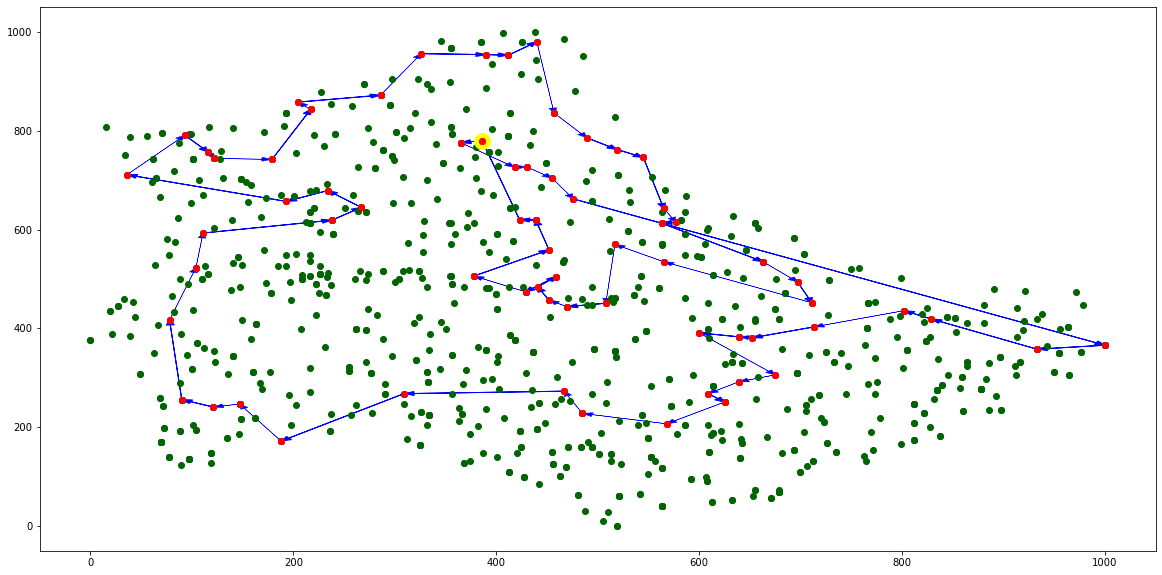

In [34]:
plt.figure(figsize=(20,10)) 
plt.scatter(data['X0'], data['Y0'], color='r', zorder=10)
plt.scatter(data['X1'], data['Y1'], color='r', zorder=10)
all_islands = plt.scatter(x, y, color='DarkGreen', label='Group 1')
home_land = plt.scatter(cords_tour[0][0], cords_tour[0][1], color='Yellow', s=250, label='Group 2')

for d in data:
    if(d['MAG'] > 0):
        plt.arrow(d['X0'],d['Y0'],d['X1']-d['X0'], d['Y1']-d['Y0'], 
         shape='full', color='b', lw=d['MAG']/2., length_includes_head=True, 
         zorder=0, head_length=10., head_width=8.)
plt.show()

In [35]:
x = [point[0] for point in cords_data]
y = [point[1] for point in cords_data]

# plot_tour = [x + y for x, y in zip(cords_tour, cords_tour[1:])]
# t = [(random.uniform(1, 3),) + i for i in plot_tour]
# data = np.array(t,dtype=[('MAG','float'),('X0','float'),('Y0','float'),('X1','float'),('Y1','float')])
totalProfit = factor
H_tour = []
for i in hamiltonian_circuit:
    H_tour.append(name2point[i])
H_EDGES = list(zip(hamiltonian_circuit[:-1], hamiltonian_circuit[1:]))

plot_hamiltonian = [x + y for x, y in zip(H_tour, H_tour[1:])]
q = [(random.uniform(1, 3),) + i for i in plot_hamiltonian]
data_H = np.array(q,dtype=[('MAG','float'),('X0','float'),('Y0','float'),('X1','float'),('Y1','float')])

AttributeError: 'PathCollection' object has no attribute 'set_title'

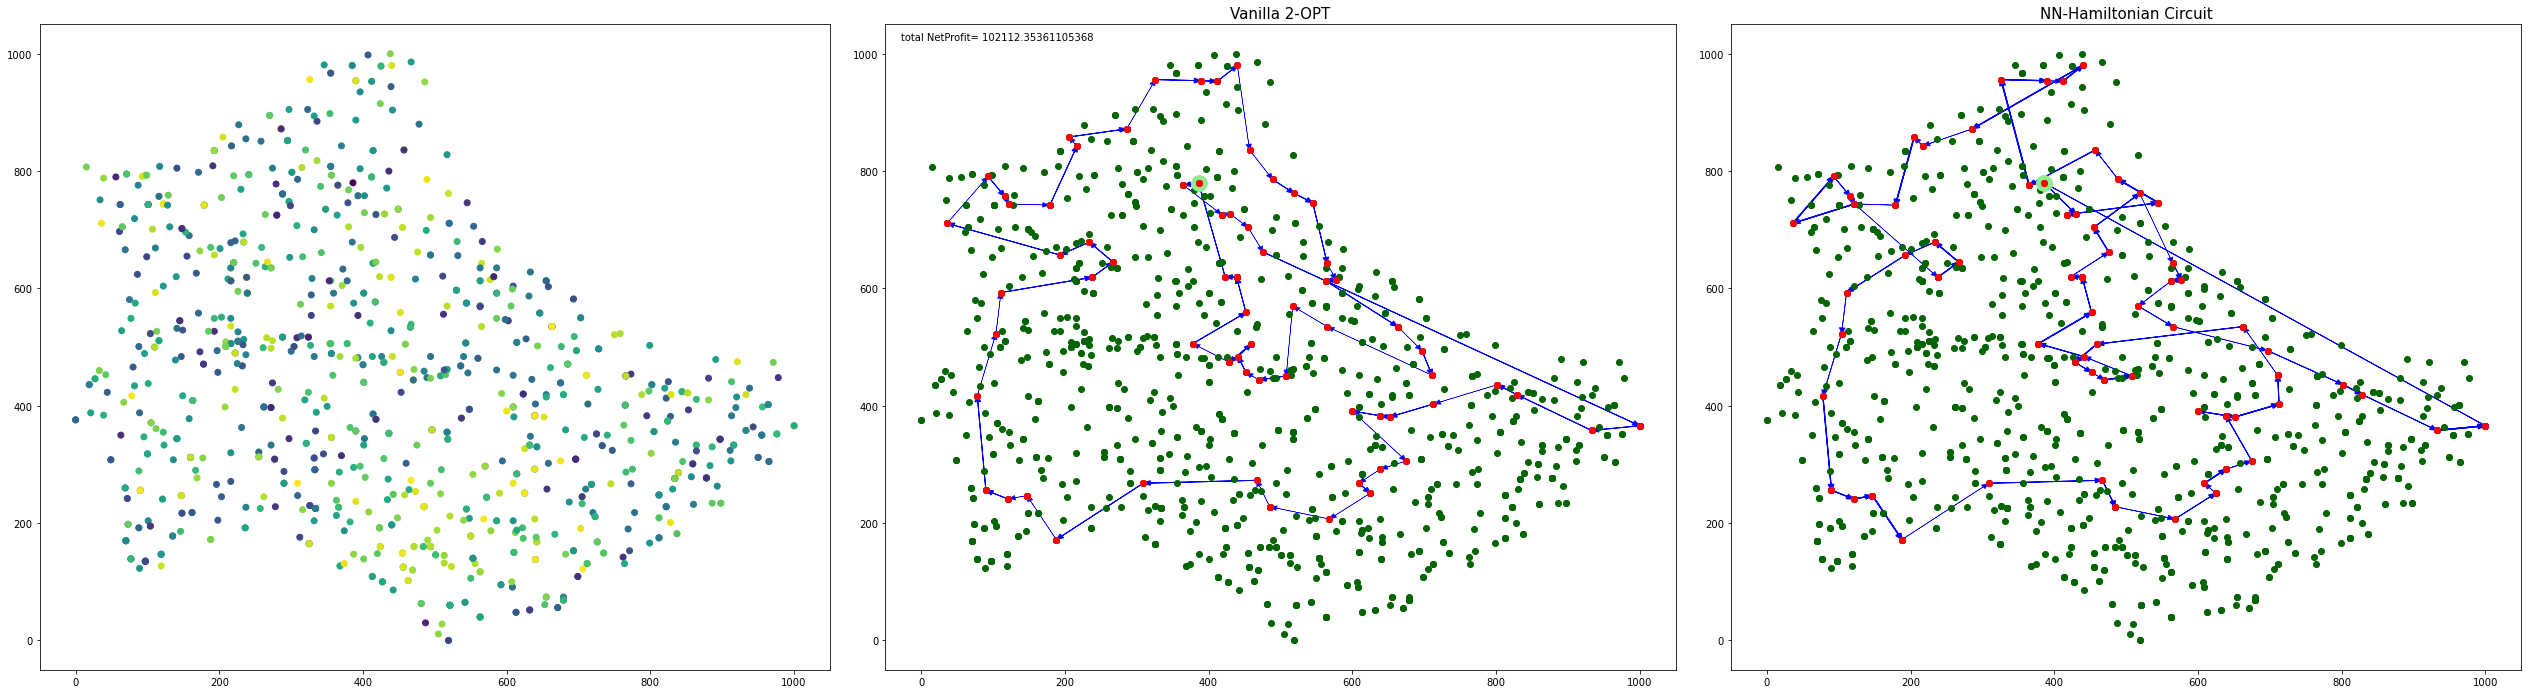

In [36]:
fig1 = plt.figure(constrained_layout=True, figsize = (35, 28))
spec2 = gridspec.GridSpec(ncols=3, nrows=3, figure=fig1)

f1_ax2 = fig1.add_subplot(spec2[0, 1])
f1_ax2.scatter(data['X0'], data['Y0'], color='r', zorder=10)
f1_ax2.scatter(data['X1'], data['Y1'], color='r', zorder=10)
all_islands = f1_ax2.scatter(x, y, color='DarkGreen', label='Group 1')
homeLand = f1_ax2.scatter(cords_tour[0][0], cords_tour[0][1], color='LightGreen', s=250)
for d in data:
    if(d['MAG'] > 0):
        plt.arrow(d['X0'],d['Y0'],d['X1']-d['X0'], d['Y1']-d['Y0'], 
         shape='full', color='b', lw=d['MAG']/2., length_includes_head=True, 
         zorder=0, head_length=10., head_width=8.)
f1_ax2.set_title('Vanilla 2-OPT', fontsize=15)
f1_ax2.annotate('total NetProfit= {}'.format(totalProfit), (0.02, 0.98), xycoords='axes fraction', va='center')

f1_ax3 = fig1.add_subplot(spec2[0, 2])
f1_ax3.scatter(data_H['X0'], data_H['Y0'], color='r', zorder=10)
f1_ax3.scatter(data_H['X1'], data_H['Y1'], color='r', zorder=10)
all_islands = f1_ax3.scatter(x, y, color='DarkGreen', label='Group 1')
homeLand = f1_ax3.scatter(H_tour[0][0], H_tour[0][1], color='LightGreen', s=250)
for d in data_H:
    if(d['MAG'] > 0):
        plt.arrow(d['X0'],d['Y0'],d['X1']-d['X0'], d['Y1']-d['Y0'], 
         shape='full', color='b', lw=d['MAG']/2., length_includes_head=True, 
         zorder=0, head_length=10., head_width=8.)
f1_ax3.set_title('NN-Hamiltonian Circuit', fontsize=15)


f1_ax1 = fig1.add_subplot(spec2[0, 0])
x = np.asarray(x_cords)
y = np.asarray(y_cords)
m = np.asarray(m_amount)

f1_ax1 = plt.scatter(x, y, c = m, label='Group 1')
f1_ax1.set_title('Given Dataset', fontsize=15)
f1_ax1.annotate('total number of islands= {}'.format(n_islands), (0.02, 0.98), xycoords='axes fraction', va='center')


One more way, to think about it, is that we should have a complete spiderweb, if our tour is correct.

In [ ]:
# Tour Profit=  1113665
# Tour Cost=  569878.1897756936
# Net profit from Nearest Neighbor: 543786.8102243064
# Net profit after 2-Opt Approach: 711733.643770285

In [ ]:
# Tour Profit=  26177
# Tour Cost=  13959.028249954545
# [0, 427, 174, 595, 890, 431, 413, 424, 698, 302, 360, 195, 13, 561, 250, 311, 181, 673, 251, 660, 543, 194, 715, 0] 24
# Net profit from BestFactor_circuit : 12217.971750045455
# Net profit after 2-Opt Approach: 12218.624273808262
# 0 427 174 595 890 431 413 424 698 302 360 195 13 561 250 311 181 673 251 715 194 543 660 0

In [ ]:
# Tour Profit=  107168
# Tour Cost=  5724.717251451262
# [0, 469, 225, 31, 253, 303, 427, 181, 660, 543, 194, 195, 96, 951, 912, 749, 146, 587, 124, 10, 471, 656, 363, 544, 425, 11, 556, 529, 337, 956, 285, 533, 5, 480, 909, 972, 646, 913, 855, 756, 850, 594, 678, 307, 880, 946, 160, 827, 817, 412, 352, 92, 75, 944, 9, 820, 206, 576, 249, 868, 238, 284, 448, 514, 151, 34, 638, 657, 200, 719, 0] Visiting 71 Islands in total
# Net profit from BestFactor_circuit : 101443.28274854874
# Net profit after 2-Opt Approach: 101443.28274854874
# 0 469 225 31 253 303 427 181 660 543 194 195 96 951 912 749 146 587 124 10 471 656 363 544 425 11 556 529 337 956 285 533 5 480 909 972 646 913 855 756 850 594 678 307 880 946 160 827 817 412 352 92 75 944 9 820 206 576 249 868 238 284 448 514 151 34 638 657 200 719 0

Reading a File in a reverse order

In [ ]:
import os

def reverse_readline(filename, buf_size=8192):
    """A generator that returns the lines of a file in reverse order"""
    with open(filename) as fh:
        segment = None
        offset = 0
        fh.seek(0, os.SEEK_END)
        file_size = remaining_size = fh.tell()
        while remaining_size > 0:
            offset = min(file_size, offset + buf_size)
            fh.seek(file_size - offset)
            buffer = fh.read(min(remaining_size, buf_size))
            remaining_size -= buf_size
            lines = buffer.split('\n')
            # The first line of the buffer is probably not a complete line so
            # we'll save it and append it to the last line of the next buffer
            # we read
            if segment is not None:
                # If the previous chunk starts right from the beginning of line
                # do not concat the segment to the last line of new chunk.
                # Instead, yield the segment first 
                if buffer[-1] != '\n':
                    lines[-1] += segment
                else:
                    yield segment
            segment = lines[0]
            for index in range(len(lines) - 1, 0, -1):
                if lines[index]:
                    yield lines[index]
        # Don't yield None if the file was empty
        if segment is not None:
            yield segment

In [ ]:
list(reverse_readline("./initializer/bin_data_1.txt"))

In [ ]:
def FFD(v, B):
    n = len(v)
    remain = [B]
    sol = [[]]
    for item in v:
        for j,free in enumerate(remain):
            if free >= item:
                remain[j] -= item
                sol[j].append(item)
                break
        else:
            sol.append([item])
            remain.append(B-item)
    return sol

In [ ]:
B = 100
v = [6,12,15,40,43,82]
FFD(v, B)

Finding the duplicated element

In [ ]:
l = [1,2,3,4,4,5,5,6,1]
set([x for x in l if l.count(x) > 1])

Pairwise Profit

In [ ]:
for twoPoints in plot_tour:
    pairwise_profit = {}
    cords_one = (twoPoints[0], twoPoints[1])
    cords_two = (twoPoints[2], twoPoints[3])
    island1 = point2name[cords_one]
    island2 = point2name[cords_two]
    pairwise_profit[(cords_one, cords_two)] = factor_calc(island1, island2)
    
pairwise_profit